In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u


plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,b,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.b     = b
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -b*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(b*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -b*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.05)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)


#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)

#############################
# define rings
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(1)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

back_ind = np.where(Rings.y>=y_offset)
fore_ind = np.where(Rings.y<=y_offset)

scouse_fits = pd.read_csv('final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

cat = pd.read_csv('CMZ_cloud_catalogue_data.csv')

###Read in data to scatter plot in lbv 
cat_tab = Table.read("synth_table.tex")


cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
l = cat_tab['l']
b = cat_tab['b']
v = cat_tab['v']
sigma = cat_tab['sigma']
rad = cat_tab['rad']
NF_decision = cat_tab['NF_decision']
absorp_NF = cat_tab['absorp_NF']
lb_pixel_mask = cat_tab['lb_pixel_mask']


## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position
cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]
pixel_mask = np.where(cat_tab['lb_pixel_mask']==1.)[0]

In [3]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    data = pd.read_csv(path, sep=sep, header=None, names=names)
    lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    
    #Find near and far point
    
    return lk,bk,vk,NF

# Fitting in both LBV + N/F Space

In [15]:
## pull out indicies of N and F distinctions
catN_ind = np.hstack((np.where(cat_tab['NF_decision']=='N'),np.where(cat_tab['NF_decision']=='LN') ))
catN_ind.sort()
catF_ind = np.hstack((np.where(cat_tab['NF_decision']=='F'),np.where(cat_tab['NF_decision']=='LF') ))
catF_ind.sort()

cat_tab_NF = np.where(cat_tab['NF_decision'])

## pull out indicies of N and F distinctions for the absorption method N/F distinctions only
catN_ind = np.hstack((np.where(cat_tab['absorp_NF']=='N'),np.where(cat_tab['absorp_NF']=='LN') ))
catN_ind.sort()
catF_ind = np.hstack((np.where(cat_tab['absorp_NF']=='F'),np.where(cat_tab['absorp_NF']=='LF') ))
catF_ind.sort()

cat_tab_NF = cat_tab['absorp_NF']

In [5]:
def normalizelbv(l,b,v, l0,b0,v0):
    #using approximate extents of the data in l,b,v to normalize between 0 and 1
    norml = (l - -0.8) / (0.8 - -0.8) 
    normb = (b - -0.28)/(0.1--0.28)
    normv = (v - -110)/(100--110)
    
    norml0 = (l0 - -0.8) / (0.8 - -0.8)
    normb0 = (b0 - -0.28)/(0.1--0.28)
    normv0 = (v0 - -110)/(100--110)
    
    return norml,normb,normv, norml0,normb0,normv0

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index

In [111]:
itsamatch = 0.25 #threshold for lbv distance (in normalized space)

### Dani's quick and dirty coding: it is neither pretty nor ~efficient~, but it works

### Run through each model. For a given cloud, find the lbv distance tothe stream
# if within the "itsamatch" threshold, it's a distance agreement
# then test for if the N/F cloud distinction agrees with the N/F model stream it is closest to


"""
#Sofue
"""
lk,bk,vk,SOF_NF = load_data('./resampled_models/sofue_resampled_300.txt')

## pull out the near/far indices of the stream to plot nicely 
SOF_nearstream_ind = np.where(SOF_NF == 'Near')[0]
sofueN_l, sofueN_b, sofueN_v = lk[SOF_nearstream_ind], bk[SOF_nearstream_ind], vk[SOF_nearstream_ind] 
    
SOF_farstream_ind = np.where(SOF_NF == 'Far')[0]
sofueF_l, sofueF_b, sofueF_v = lk[SOF_farstream_ind], bk[SOF_farstream_ind], vk[SOF_farstream_ind] 


SOF_match_full= np.zeros(len(cat_tab)) #set up array for later plotting/viz stuff


normSOF_l,normSOF_b, normSOF_v, norml0, normb0, normv0 = normalizelbv(lk,bk,vk, cat_tab['l'],cat_tab['b'], cat_tab['v']) # normalize the entire array set
agree_count = 0. #counting for 4D % agreement
dist_agree = 0. # counting for 3D distance agreement 

## sepratate matching for N/F streams, because it makes the plotting easier later
for i in catN_ind[0]:
    ind, vec = min_distancelbv(normSOF_l,normSOF_b, normSOF_v, (norml0[i],normb0[i],normv0[i])) #find distances
    min_dis = vec[ind] #extract minimum
    if min_dis<itsamatch:
        dist_agree += 1. # distance match
    if ((ind in SOF_nearstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1. # 4D match
        SOF_match_full[i] = 1.
                       
for i in catF_ind[0]:
    ind, vec = min_distancelbv(normSOF_l,normSOF_b, normSOF_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind in SOF_farstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1.
        SOF_match_full[i] = 1.

SOF_match_agg = SOF_match_full[pixel_mask]        
agree_percent = agree_count/(len(catN_ind[0])+len(catF_ind[0]))
dist_agree = dist_agree/(len(catN_ind[0])+len(catF_ind[0]))
print('Sofue Agree lbv: {:.0f}%'.format(dist_agree*100.))
print('Sofue Agree lbv,n/f: {:.0f}%'.format(agree_percent*100.))

##same general thing for the other models...

"""
#Molinari
"""
lk,bk,vk,MOL_NF = load_data('./resampled_models/molinari_resampled_300.txt')

molinari_nearstream_ind = np.where(MOL_NF == 'Near')[0]
MOLN_l,MOLN_b, MOLN_v = lk[molinari_nearstream_ind], bk[molinari_nearstream_ind],vk[molinari_nearstream_ind] 

molinari_farstream_ind = np.where(MOL_NF == 'Far')[0]
MOLF_l,MOLF_b, MOLF_v = lk[molinari_farstream_ind],bk[molinari_farstream_ind], vk[molinari_farstream_ind] 



MOL_match_full= np.zeros(len(cat_tab))
## norm the entire array set
normMOL_l,normMOL_b,normMOL_v, norml0, normb0, normv0 = normalizelbv(-1*lk,bk,vk, cat_tab['l'],cat_tab['b'], cat_tab['v'])
agree_count = 0.
dist_agree=0.
for i in catN_ind[0]:
    ind, vec = min_distancelbv(normMOL_l,normMOL_b, normMOL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind in molinari_nearstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1.
        MOL_match_full[i] = 1.

for i in catF_ind[0]:
    ind, vec = min_distancelbv(normMOL_l,normMOL_b, normMOL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind in molinari_farstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the far stream
        agree_count += 1.
        MOL_match_full[i] = 1.


MOL_match_agg = MOL_match_full[pixel_mask]
agree_percent = agree_count/(len(catN_ind[0])+len(catF_ind[0]))
dist_agree = dist_agree/(len(catN_ind[0])+len(catF_ind[0]))
print('Molinari Agree lbv: {:.0f}%'.format(dist_agree*100.))
print('Molinari Agree lbv, n/f: {:.0f}%'.format(agree_percent*100.))


"""
#KDL
"""


lk,bk,vk,KDL_NF = load_data('./resampled_models/KDL_resampled_300.txt')

KDL_nearstream_ind = np.where(KDL_NF == 'Near')[0]
KDLN_l,KDLN_b, MOLN_v = lk[KDL_nearstream_ind],bk[KDL_nearstream_ind], vk[KDL_nearstream_ind] 

KDL_farstream_ind = np.where(KDL_NF == 'Far')[0]
KDLF_l,KDLF_b, KDLF_v = lk[KDL_farstream_ind], bk[KDL_farstream_ind], vk[KDL_farstream_ind] 


KDL_match_full= np.zeros(len(cat_tab))    
## norm the entire array set
normKDL_l,normKDL_b,normKDL_v, norml0, normb0, normv0 = normalizelbv(lk,bk,vk, cat_tab['l'],cat_tab['b'], cat_tab['v'])
agree_count = 0.
dist_agree = 0.
for i in catN_ind[0]:
    ind, vec = min_distancelbv(normKDL_l,normKDL_b,normKDL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind in KDL_nearstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1.
        KDL_match_full[i] = 1.
            
for i in catF_ind[0]:
    ind, vec = min_distancelbv(normKDL_l,normKDL_b,normKDL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind in KDL_farstream_ind) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1.
        KDL_match_full[i] = 1.

KDL_match_agg = KDL_match_full[pixel_mask]
agree_percent = agree_count/(len(catN_ind[0])+len(catF_ind[0]))
dist_agree = dist_agree/(len(catN_ind[0])+len(catF_ind[0]))
print('KDL Agree lbv: {:.0f}%'.format(dist_agree*100.))
print('KDL Agree lbv, n/f: {:.0f}%'.format(agree_percent*100.))


"""
#Ellipse
"""

lk,bk,vk,ELLIPSE_NF = load_data('./resampled_models/ellipse_resampled_300.txt')

ELLIPSE_nearstream_ind = np.where(ELLIPSE_NF == 'Near')[0]
ELLN_l,ELLN_b, ELLN_v = lk[ELLIPSE_nearstream_ind],bk[ELLIPSE_nearstream_ind], vk[ELLIPSE_nearstream_ind] 

ELLIPSE_farstream_ind = np.where(ELLIPSE_NF == 'Far')[0]
ELLF_l,ELLF_b, ELLF_v = lk[ELLIPSE_farstream_ind],bk[ELLIPSE_farstream_ind], vk[ELLIPSE_farstream_ind] 

ELL_match_full= np.zeros(len(cat_tab))    
    
## norm the entire array set
normELL_l,normELL_b,normELL_v, norml0, normb0, normv0 = normalizelbv(lk,bk,vk, cat_tab['l'],cat_tab['b'], cat_tab['v'])
agree_count = 0.
dist_agree = 0.
for i in catN_ind[0]:
    ind, vec = min_distancelbv(normELL_l,normELL_b,normELL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind][0]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind[0] in np.array(ELLIPSE_nearstream_ind)) & (min_dis<itsamatch)): #check if the minimum distance is on the near stream
        agree_count += 1.
        ELL_match_full[i] = 1.

for i in catF_ind[0]:
    ind, vec=min_distancelbv(normELL_l,normELL_b,normELL_v, (norml0[i],normb0[i],normv0[i]))
    min_dis = vec[ind][0]
    if min_dis<itsamatch:
        dist_agree += 1.
    if ((ind[0] in np.array(ELLIPSE_farstream_ind) )& (min_dis<itsamatch)): #check if the minimum distance is on the far stream
        agree_count += 1.
        ELL_match_full[i] = 1.
   
        
ELL_match_agg = ELL_match_full[pixel_mask]
agree_percent = agree_count/(len(catN_ind[0])+len(catF_ind[0]))
dist_agree = dist_agree/(len(catN_ind[0])+len(catF_ind[0]))
print('Ellipse Agree lbv: {:.0f}%'.format(dist_agree*100.))
print('Ellipse Agree lbv, n/f: {:.0f}%'.format(agree_percent*100.))



Sofue Agree lbv: 90%
Sofue Agree lbv,n/f: 55%
Molinari Agree lbv: 48%
Molinari Agree lbv, n/f: 23%
KDL Agree lbv: 90%
KDL Agree lbv, n/f: 65%
Ellipse Agree lbv: 87%
Ellipse Agree lbv, n/f: 61%


# LB and LV Visualizations 

In [52]:
def plot_lb_lv_points_mega(agg_match, full_match, DaniDan,axlb):
    if DaniDan == 'Dani':
        NF_agg, NF_tab = cat_agg['NF_decision'],cat_tab['NF_decision']
    if DaniDan == 'Dan':
        NF_agg, NF_tab = cat_agg['absorp_NF'],cat_tab['absorp_NF']
    for i in range(len(cat_agg)):
        if (NF_agg[i] =='N') & (agg_match[i] == 1.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='D', s=100, edgecolor='k', zorder=3, c='blue')
        if (NF_agg[i] =='LN') & (agg_match[i] == 1.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='D', s=100, edgecolor='k', zorder=3, c='cyan')

        if (NF_agg[i] =='N') & (agg_match[i] == 0.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='X', s=100, edgecolor='k', zorder=3, c='blue')             
        if (NF_agg[i] =='LN') & (agg_match[i] == 0.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='X', s=100, edgecolor='k', zorder=3, c='cyan')        

        if (NF_agg[i] =='F') & (agg_match[i] == 1.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='D', s=100, edgecolor='k', zorder=3, c='red')    
        if (NF_agg[i] =='F') & (agg_match[i] == 0.):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='X', s=100, edgecolor='k', zorder=3, c='red')

        if (NF_agg[i] =='U'):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='o', s=100, edgecolor='k', zorder=3, c='gray')

        if (NF_agg[i] =='nan'):
            sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='x', s=100, edgecolor='k', zorder=3, c='gray')
    
    for i in range(len(cat_tab)):
        if (NF_tab[i] =='N') & (full_match[i] ==1.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='D', s=100, edgecolor='k', zorder=3, c='blue')
        if (NF_tab[i] =='LN') & (full_match[i]==1.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='D', s=100, edgecolor='k', zorder=3, c='cyan')

        if (NF_tab[i] =='N') & (full_match[i] ==0.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='X', s=100, edgecolor='k', zorder=3, c='blue')             
        if (NF_tab[i] =='LN') & (full_match[i]==0.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='X', s=100, edgecolor='k', zorder=3, c='cyan')        

        if (NF_tab[i] =='F') & (full_match[i] ==1.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='D', s=100, edgecolor='k', zorder=3, c='red')    
        if (NF_tab[i] =='F') & (full_match[i]==0.):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='X', s=100, edgecolor='k', zorder=3, c='red')

        if (NF_tab[i] =='U'):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='o', s=100, edgecolor='k', zorder=3, c='gray')

        if (NF_tab[i] =='nan'):
            sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='x', s=100, edgecolor='k', zorder=3, c='gray')
            
            
    ax[axlb][0].grid(True)
    ax[axlb][0].set_xlim(1,-0.65)
    ax[axlb][0].set_ylim(-0.3,0.15)
    ax[axlb][0].set_rasterized(True)
    ax[axlb][1].grid(True)
    ax[axlb][1].set_xlim(1,-0.65)
    ax[axlb][1].set_ylim(-140,140)
    ax[axlb][1].set_rasterized(True)
    
    

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_94307/2660964469.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = ax[axlb][0].scatter(cat_agg['l'][i], cat_agg['b'][i], marker='x', s=100, edgecolor='k', zorder=3, c='gray')
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_94307/2660964469.py:48: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = ax[axlb][1].scatter(cat_tab['l'][i], cat_tab['v'][i], marker='x', s=100, edgecolor='k', zorder=3, c='gray')
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_94307/2660964469.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the faceco

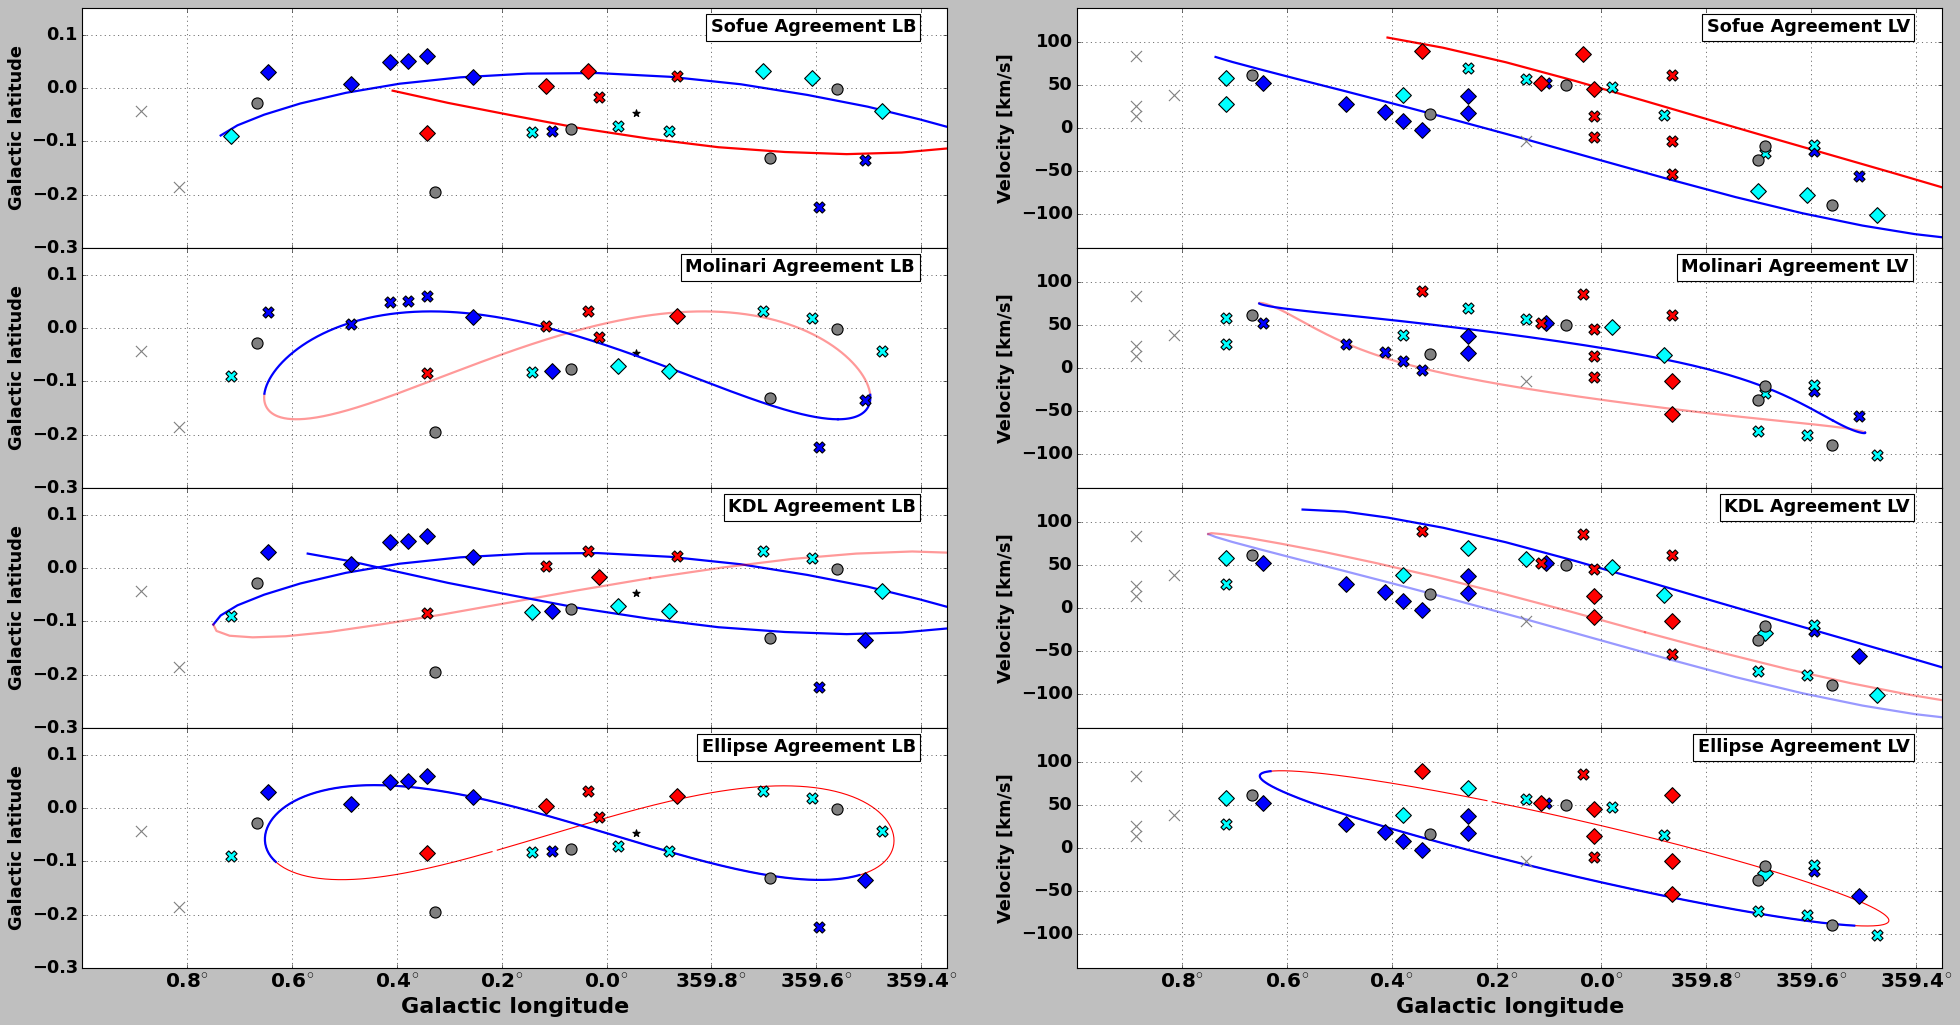

In [108]:
### SOFUE ###
sofueN = np.loadtxt('sofue_lbv_arm1.txt', unpack=True)
sofueN_l, sofueN_b, sofueN_v = sofueN[0], sofueN[1], sofueN[2]
sofueF = np.loadtxt('sofue_lbv_arm2.txt', unpack=True)
sofueF_l, sofueF_b, sofueF_v = sofueF[0], sofueF[1], sofueF[2]

### MOLINARI ###
ml = np.loadtxt('molinari_lbvlos.txt', unpack=True)
mlk, mbk, mvk = ml[0], ml[1], ml[2]

### KDL ###
kdl = np.loadtxt('kdl_lbv.txt', unpack=True)
klk, kbk, kvk = kdl[0], kdl[1], kdl[2]



fig, ax = plt.subplots(nrows=4, ncols=2,  figsize=(30,15))
plt.subplots_adjust(wspace=0.15, hspace=0)













ax[0][0].plot(sofueN_l, sofueN_b, ls='-', color='blue', linewidth=2, zorder=2)
ax[0][0].plot(sofueF_l, sofueF_b, ls='-', color='red', linewidth=2, zorder=2)
ax[0][0].text(0.845, 0.92,'Sofue Agreement LB', ha='center', va='center', transform=ax[0][0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0][0].xaxis.set_ticklabels([])
#ax[0][0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[0][0].set_ylabel('Galactic latitude')

ax[0][1].plot(sofueN_l, sofueN_v, ls='-', color='blue', linewidth=2, zorder=2)
ax[0][1].plot(sofueF_l, sofueF_v, ls='-', color='red', linewidth=2, zorder=2)
ax[0][1].text(0.845, 0.92,'Sofue Agreement LV', ha='center', va='center', transform=ax[0][1].transAxes,
       bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[0][1].xaxis.set_ticklabels([])
ax[0][1].set_ylabel('Velocity [km/s]')


plot_lb_lv_points_mega(SOF_match_agg, SOF_match_full, 'Dani', 0)


ax[1][0].plot(-1*mlk[80:580], mbk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1][0].plot(-1*mlk[0:80], mbk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1][0].plot(-1*mlk[581:], mbk[581:], ls='-', color='blue', linewidth=2, zorder=2)

ax[1][0].text(0.83, 0.92,'Molinari Agreement LB', ha='center', va='center', transform=ax[1][0].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[1][0].xaxis.set_ticklabels([])
#ax[1][0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[1][0].set_ylabel('Galactic latitude')


ax[1][1].plot(-1*mlk[80:580], mvk[80:580], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[1][1].plot(-1*mlk[0:80], mvk[0:80], ls='-', color='blue', linewidth=2, zorder=2)
ax[1][1].plot(-1*mlk[581:], mvk[581:], ls='-', color='blue', linewidth=2, zorder=2)

ax[1][1].text(0.83, 0.92,'Molinari Agreement LV', ha='center', va='center', transform=ax[1][1].transAxes,
           bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[1][1].xaxis.set_ticklabels([])
ax[1][1].set_ylabel('Velocity [km/s]')



plot_lb_lv_points_mega(MOL_match_agg, MOL_match_full , 'Dani',1)


        
ax[2][0].plot(lk[0:16], bk[0:16], ls='-', color='blue', linewidth=2, zorder=2)
ax[2][0].plot(lk[15:26], bk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2][0].plot(lk[25:36], bk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2][0].plot(lk[35:51], bk[35:51], ls='-', color='blue', linewidth=2, zorder=2)


ax[2][0].text(0.855, 0.92,'KDL Agreement LB', ha='center', va='center', transform=ax[2][0].transAxes,
        bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[2][0].xaxis.set_ticklabels([])
#ax[2][0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[2][0].set_ylabel('Galactic latitude')


ax[2][1].plot(lk[0:16], vk[0:16], ls='-', color='blue', linewidth=2, zorder=2, alpha=0.4)
ax[2][1].plot(lk[15:26], vk[15:26], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2][1].plot(lk[25:36], vk[25:36], ls='-', color='red', linewidth=2, zorder=2, alpha=0.4)
ax[2][1].plot(lk[35:51], vk[35:51], ls='-', color='blue', linewidth=2, zorder=2)


ax[2][1].text(0.855, 0.92,'KDL Agreement LV', ha='center', va='center', transform=ax[2][1].transAxes,
        bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[2][1].xaxis.set_ticklabels([])
ax[2][1].set_ylabel('Velocity [km/s]')

plot_lb_lv_points_mega(KDL_match_agg, KDL_match_full, 'Dani',2)


ax[3][0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
ax[3][0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


ax[3][0].text(0.84, 0.92,'Ellipse Agreement LB', ha='center', va='center', transform=ax[3][0].transAxes,
       bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[3][0].set_xlabel('Galactic longitude', fontsize=20)
ax[3][0].xaxis.set_ticklabels([])
#ax[3][0].yaxis.set_ticklabels([-.30," " , -0.20," " , -.10," " , 0.00," " , " "])
ax[3][0].set_ylabel('Galactic latitude')


ax[3][1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax[3][1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)


ax[3][1].text(0.84, 0.92,'Ellipse Agreement LV', ha='center', va='center', transform=ax[3][1].transAxes,
       bbox=dict(facecolor='white', edgecolor='k', alpha=1))
ax[3][1].set_xlabel('Galactic longitude', fontsize=20)
ax[3][1].set_ylabel('Velocity [km/s]')

plot_lb_lv_points_mega(ELL_match_agg, ELL_match_full, 'Dani',3)


ax[0][0].scatter(-0.056, -0.046, marker = "*", s=45, color='k')
ax[1][0].scatter(-0.056, -0.046, marker = "*", s=45, color='k')
ax[2][0].scatter(-0.056, -0.046, marker = "*", s=45, color='k')
ax[3][0].scatter(-0.056, -0.046, marker = "*", s=45, color='k')

ax[3][0].xaxis.set_ticklabels([r'',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
                       r'0.4$^{\circ}$',r'0.6$^{\circ}$',r'0.8$^{\circ}$',], fontsize=18)
ax[3][1].xaxis.set_ticklabels([r'359.2$^{\circ}$}',r'359.4$^{\circ}$',r'359.6$^{\circ}$',r'359.8$^{\circ}$',r'0.0$^{\circ}$',r'0.2$^{\circ}$',
                           r'0.4$^{\circ}$',r'0.6$^{\circ}$',r'0.8$^{\circ}$',r''], fontsize=18)


plt.savefig('./percent_agreement_300_sample.pdf', bbox_inches='tight')